In [1]:
# Cell 1
# Import libraries
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


2023-11-01 11:11:56.845694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cell 2
# Load your Excel files for training and validation
train_file_path = '/Users/PremGanesh/Developer/Cyvidia/CyVidia/Input_Data/Training Dataset.xlsx'
train_df = pd.read_excel(train_file_path)

# Print the shape of the training data
print(train_df.shape)

(2473, 16)


In [3]:
# Cell 3
# Define a function for text cleaning
def clean_text(text):
    if isinstance(text, float) and np.isnan(text):
        return ""
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    clean_text = ' '.join(words)
    return clean_text

In [4]:
# Cell 4
# Apply text cleaning to 'Requirement Description' column for training and validation data
train_df['Cleaned_Description'] = train_df['Requirement Description'].apply(clean_text)

In [5]:
# Cell 5
# Tokenize and pad sequences for training data
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['Cleaned_Description'])
X_train = tokenizer.texts_to_sequences(train_df['Cleaned_Description'])
X_train = pad_sequences(X_train, maxlen=100)

In [6]:

# Cell 6
# Label encode 'Requirement Area' for training data
area_encoder = LabelEncoder()
train_df['Requirement Area (NIST)'] = train_df['Requirement Area (NIST)'].str.lower()
y_area_train = area_encoder.fit_transform(train_df['Requirement Area (NIST)'])

In [7]:
# Cell 7
# Label encode 'Requirement Bucket(NIST)' for training data
bucket_encoder = LabelEncoder()
train_df['Requirement Bucket(NIST)'] = train_df['Requirement Bucket(NIST)'].str.lower()
y_bucket_train = bucket_encoder.fit_transform(train_df['Requirement Bucket(NIST)'])

In [8]:
# Cell 8
# Split data into training and validation sets for evaluation
X_train, X_valid, y_area_train, y_area_valid, y_bucket_train, y_bucket_valid = train_test_split(
    X_train, y_area_train, y_bucket_train, test_size=0.2, random_state=42)

model_file_path = 'trained_model'

In [9]:
# Cell 9
# Check if the model file exists and load it, or create a new model
if os.path.exists(model_file_path):
    model = tf.keras.models.load_model(model_file_path)
else:
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=100))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    output_area = Dense(len(area_encoder.classes_), activation='softmax', name='output_area')(model.layers[-1].output)
    output_bucket = Dense(len(bucket_encoder.classes_), activation='softmax', name='output_bucket')(model.layers[-1].output)
    model = Model(inputs=model.input, outputs=[output_area, output_bucket])
    model.compile(
        loss={'output_area': 'sparse_categorical_crossentropy', 'output_bucket': 'sparse_categorical_crossentropy'},
        optimizer='adam',
        metrics={'output_area': 'accuracy', 'output_bucket': 'accuracy'}
    )


In [10]:
# Cell 10
# Train the model on training data with both labels and store the training history
history = model.fit(X_train, {'output_area': y_area_train, 'output_bucket': y_bucket_train}, epochs=200, batch_size=32)


Epoch 1/200
62/62 [==============================] - 9s 94ms/step - loss: 0.4666 - output_area_loss: 0.2016 - output_bucket_loss: 0.2651 - output_area_accuracy: 0.9166 - output_bucket_accuracy: 0.8817
Epoch 2/200
62/62 [==============================] - 6s 96ms/step - loss: 0.4734 - output_area_loss: 0.1934 - output_bucket_loss: 0.2800 - output_area_accuracy: 0.9226 - output_bucket_accuracy: 0.8913
Epoch 3/200
62/62 [==============================] - 6s 94ms/step - loss: 0.4663 - output_area_loss: 0.1838 - output_bucket_loss: 0.2825 - output_area_accuracy: 0.9216 - output_bucket_accuracy: 0.8777
Epoch 4/200
62/62 [==============================] - 8s 125ms/step - loss: 0.4649 - output_area_loss: 0.1966 - output_bucket_loss: 0.2683 - output_area_accuracy: 0.9146 - output_bucket_accuracy: 0.8883
Epoch 5/200
62/62 [==============================] - 5s 85ms/step - loss: 0.4598 - output_area_loss: 0.2004 - output_bucket_loss: 0.2594 - output_area_accuracy: 0.9135 - output_bucket_accuracy: 0

In [11]:
# Cell 11
# Save the model to a file in the TensorFlow SavedModel format
model.save(model_file_path)


INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets


In [12]:

# Cell 12
# Save the tokenizer using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:



# Cell 13
# Save the encoders using pickle
with open('area_encoder.pickle', 'wb') as handle:
    pickle.dump(area_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('bucket_encoder.pickle', 'wb') as handle:
    pickle.dump(bucket_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


system and communications protection 323
access control 266
system and services acquisition 241
system and information integrity 238
identification and authentication 151
configuration management 149
incident response 138
audit and accountability 120
contingency planning 111
physical and environmental protection 107
program management 106
supply chain risk management 79
assessment, authorization and monitoring 78
risk assessment 69
maintenance 62
personally identifiable information processing and transparency 55
media protection 54
awareness and training 47
personnel security 41
planning 38


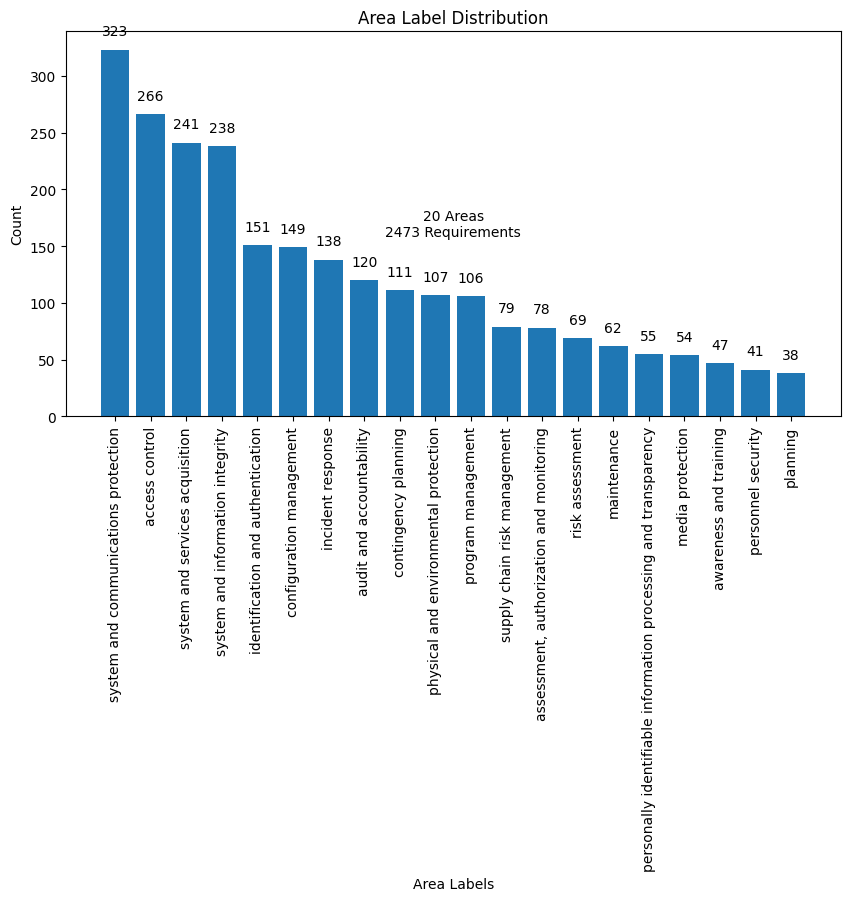

In [14]:
# Visualize label distribution for 'Area'
import matplotlib.pyplot as plt

# Get the sorted area labels and their counts
area_labels, area_counts = zip(*sorted(zip(train_df['Requirement Area (NIST)'].value_counts().index, train_df['Requirement Area (NIST)'].value_counts()), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(area_labels, area_counts)
plt.xticks(rotation=90)

# add title with the number of areas and the total number of requirements
plt.title('Area Label Distribution')
plt.text(0.5, 0.5, str(len(area_labels)) + ' Areas\n' + str(len(train_df)) + ' Requirements',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Area Labels')
plt.ylabel('Count')
#PRINT COUNT OF EACH AREA
for i, v in enumerate(area_counts):
    print(area_labels[i], v)
   
# add count values on top of the bars
for i, v in enumerate(area_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.show()


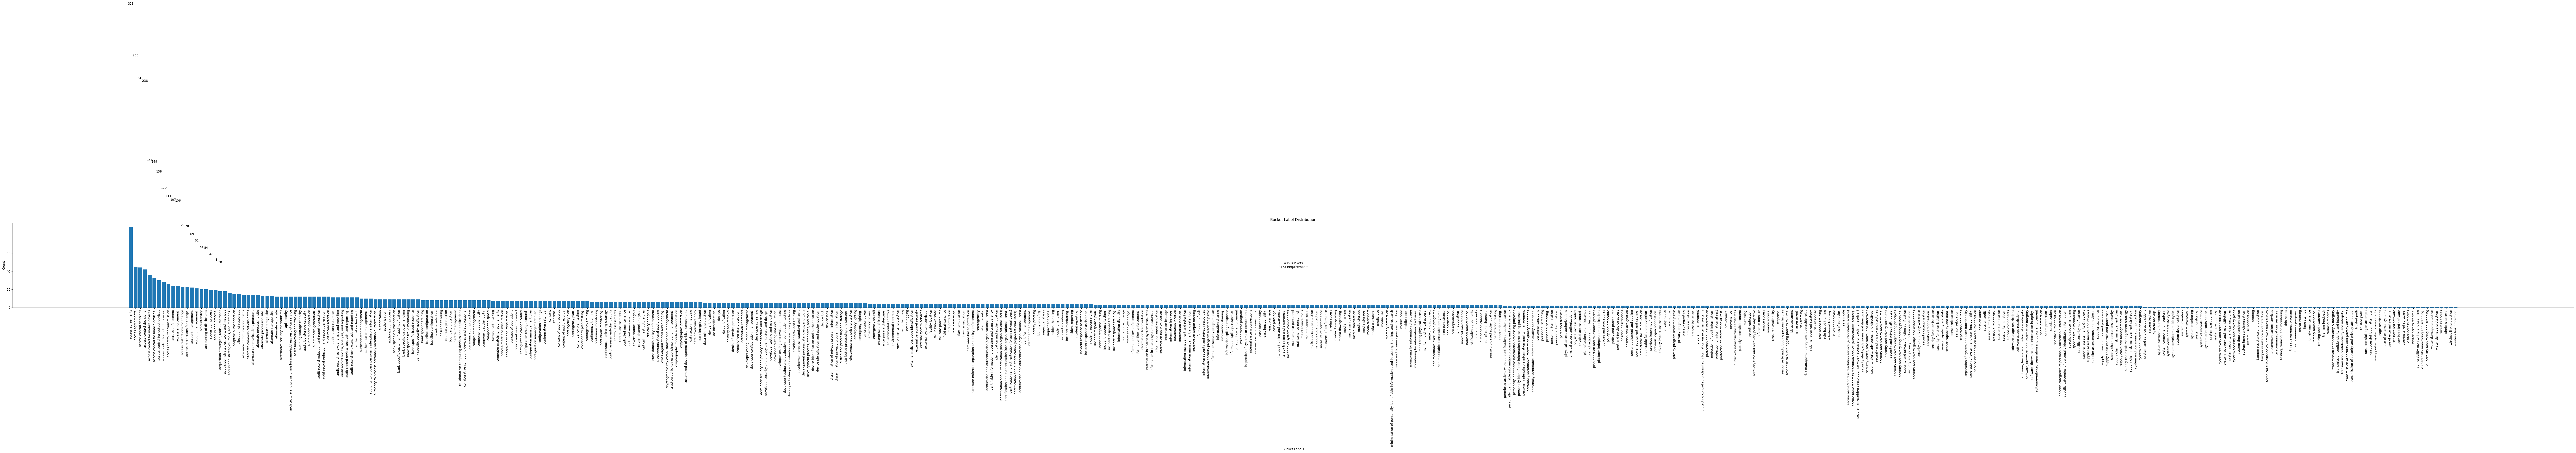

In [15]:

# Cell 15
# Visualize label distribution for 'Bucket'
plt.figure(figsize=(150, 5))
#start from 0 to 150
plt.bar(bucket_encoder.classes_, train_df['Requirement Bucket(NIST)'].value_counts())
#rotate the labels by 90 degrees
plt.xticks(rotation=90)
#add title with no.of buckets and total no.of requirements
plt.title('Bucket Label Distribution')
plt.text(0.5, 0.5, str(len(bucket_encoder.classes_)) + ' Buckets\n' + str(len(train_df)) + ' Requirements',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#label the x and y axis
plt.xlabel('Bucket Labels')
plt.ylabel('Count')
#display the count of each label
# add count values on top of the bars
for i, v in enumerate(area_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')



plt.show()

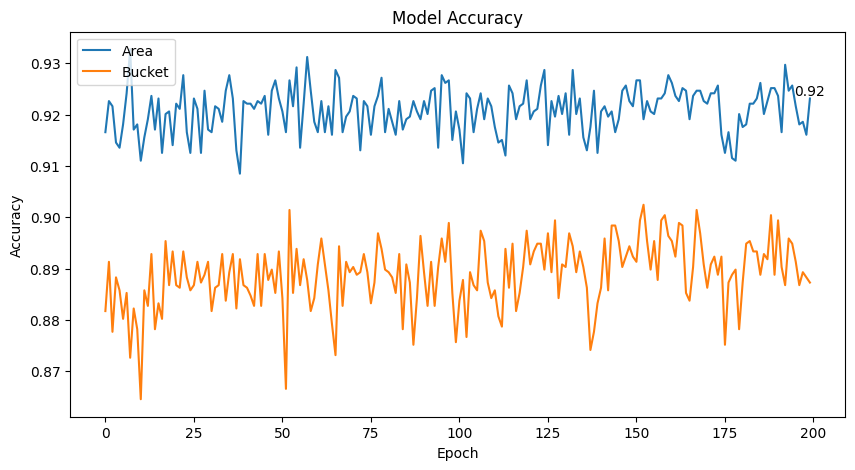

In [16]:
# Cell 16
# Visualize training history for 'Area' and 'Bucket'
plt.figure(figsize=(10, 5))
plt.plot(history.history['output_area_accuracy'])
plt.plot(history.history['output_bucket_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Area', 'Bucket'], loc='upper left')
# add highest accuracy values on top of the lines
plt.text(len(history.history['output_area_accuracy']) - 1, history.history['output_area_accuracy'][-1],
         str(round(history.history['output_area_accuracy'][-1], 2)), ha='center', va='bottom')
plt.show()
